In [ ]:
import requests
import csv
import time

TMDB_API_KEY = "158da0f869c4549c3cf52a4efe1d2b52"

POPULAR_MOVIES_URL = "https://api.themoviedb.org/3/movie/popular?api_key={}&language=en-US&page={}"
REVIEW_URL_TEMPLATE = "https://api.themoviedb.org/3/movie/{}/reviews?api_key={}&language=en-US&page=1"

with open("movie_review.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["movie_id", "movie_name", "one_movie_review"])  # CSV Header

    total_movies = 0
    page = 1

    while total_movies < 10000:

        response = requests.get(POPULAR_MOVIES_URL.format(TMDB_API_KEY, page))
        movies = response.json().get("results", [])

        if not movies:
            print("⚠️ No more movies found. Stopping...")
            break

        for movie in movies:
            if total_movies >= 10000:
                break

            movie_id = movie["id"]
            movie_name = movie["title"]

            review_response = requests.get(REVIEW_URL_TEMPLATE.format(movie_id, TMDB_API_KEY))
            reviews = review_response.json().get("results", [])

            review_text = reviews[0]["content"] if reviews else "No reviews available"

            
            writer.writerow([movie_id, movie_name, review_text])

            total_movies += 1
            print(f"✅ Collected {total_movies}: {movie_name}")

        
        page += 1
        time.sleep(0.5)  

print("🎉 10000 Movie reviews collected and stored in 'movie_review.csv'.")

Streaming output truncated to the last 5000 lines.
✅ Collected 5002: Alien from the Darkness
✅ Collected 5003: The King's Daughter
✅ Collected 5004: Hall Pass
✅ Collected 5005: Antlers
✅ Collected 5006: Ghosts of Girlfriends Past
✅ Collected 5007: Just Like Heaven
✅ Collected 5008: Piston Cup: Legacy
✅ Collected 5009: Hotel Bitcoin
✅ Collected 5010: Monsters 103 Mercies Dragon Damnation
✅ Collected 5011: The Underdoggs
✅ Collected 5012: Bade Miyan Chote Miyan
✅ Collected 5013: Oculus
✅ Collected 5014: Facing the Giants
✅ Collected 5015: Miss Congeniality 2: Armed and Fabulous
✅ Collected 5016: Cube
✅ Collected 5017: The Layover
✅ Collected 5018: Magnolia
✅ Collected 5019: The Shepherd: Border Patrol
✅ Collected 5020: Damage
✅ Collected 5021: Black Water
✅ Collected 5022: Monster High 2
✅ Collected 5023: Juggernaut
✅ Collected 5024: EverAfter
✅ Collected 5025: The Water Horse
✅ Collected 5026: Lady and the Tramp II: Scamp's Adventure
✅ Collected 5027: BlacKkKlansman
✅ Collected 5028: Yo

In [ ]:
import pandas as pd

df = pd.read_csv("movie_review.csv")


print(df.shape)  
df.head()        
null_counts = df.isnull().sum()
print(null_counts)
no_review_count = df['one_movie_review'].isnull().sum() + (df['one_movie_review'].str.strip() == "").sum()
print(f"Number of rows with no reviews: {no_review_count}")


(10000, 3)
movie_id            0
movie_name          0
one_movie_review    0
dtype: int64
Number of rows with no reviews: 0


In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns            
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df = pd.read_csv("movie_review.csv")

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(review):
    if pd.isna(review) or review.strip() == "No reviews available":
        return "Neutral"  
    sentiment_score = analyzer.polarity_scores(review)["compound"]
    if sentiment_score >= 0.05:
        return "Positive"
    elif sentiment_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["one_movie_review"].apply(get_sentiment)

df.to_csv("movie_review_with_sentiment.csv", index=False)

print(df.head(10))
print(df.tail(10))

   movie_id                        movie_name  \
0    950396                         The Gorge   
1    762509             Mufasa: The Lion King   
2   1126166                       Flight Risk   
3   1241982                           Moana 2   
4    939243              Sonic the Hedgehog 3   
5    927342                            Amaran   
6    822119  Captain America: Brave New World   
7   1160956                        Panda Plan   
8   1084199                         Companion   
9   1294203                  My Fault: London   

                                    one_movie_review sentiment  
0  FULL SPOILER-FREE REVIEW @ https://talkingfilm...  Positive  
1  Rubbish poster aside, <em>'Mufasa: The Lion Ki...  Positive  
2  <em>'Flight Risk'</em> is a film that I'm not ...  Positive  
3  When "Moana" learns that the whole of Pacific ...  Positive  
4  So for fifty years, "GUN" have kept "Shadow" i...  Positive  
5  Amaran is a moving tribute to Major Mukund Var...  Positive  
6  <e

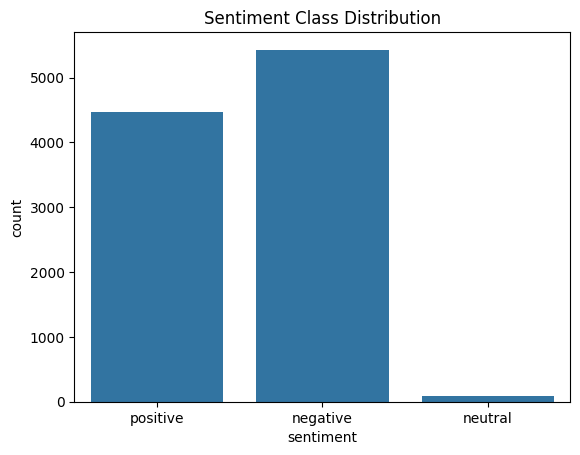

sentiment
negative    5431
positive    4474
neutral       95
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Class Distribution")
plt.show()
print(df["sentiment"].value_counts())

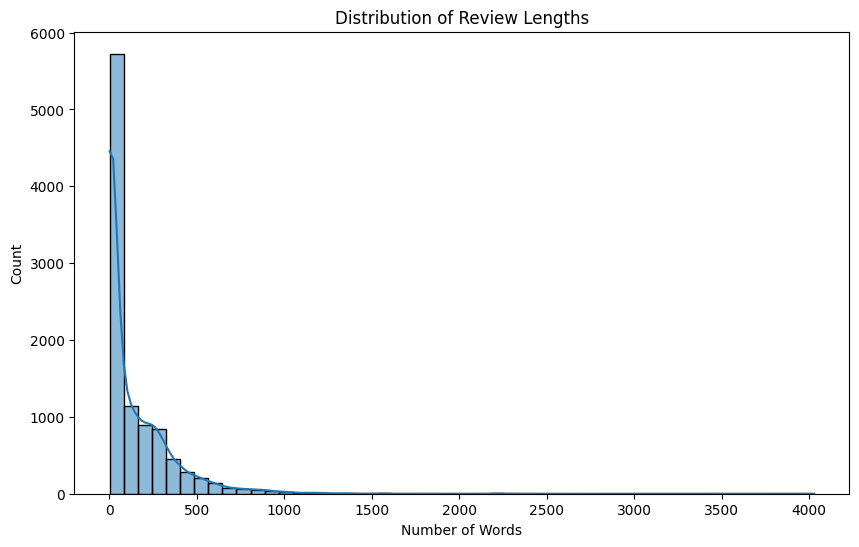

review_length
3       4244
24        36
33        33
31        32
53        30
        ... 
986        1
1111       1
1015       1
1009       1
657        1
Name: count, Length: 852, dtype: int64


In [ ]:
df['review_length'] = df['one_movie_review'].apply(lambda x: len(str(x).split()))


plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.show()
print(df["review_length"].value_counts())


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(sentiment_label, top_n=20):
    
    sentiment_reviews = df[df['sentiment'] == sentiment_label]['one_movie_review'].dropna()


    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    X_vectorized = vectorizer.fit_transform(sentiment_reviews)

    
    word_counts = X_vectorized.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()

    
    word_freq = sorted(zip(words, word_counts), key=lambda x: x[1], reverse=True)

    
    return [word for word, count in word_freq]


positive_words = get_top_words("positive")
negative_words = get_top_words("negative")
neutral_words = get_top_words("neutral")


print("Top Positive Words:", positive_words)
print("Top Negative Words:", negative_words)
print("Top Neutral Words:", neutral_words)


Top Positive Words: ['film', 'movie', 'like', 'story', 'just', 'good', 'time', 'really', 'great', 'character', 'way', 'characters', 'best', 'watch', 'films', 'action', 'quite', 'does', 'little', 'don']
Top Negative Words: ['reviews', 'available', 'film', 'movie', 'just', 'story', 'like', 'really', 'time', 'good', 'horror', 'bad', 'way', 'don', 'quite', 'character', 'make', 'action', 'people', 'characters']
Top Neutral Words: ['film', 'movie', 'just', 'story', 'like', 'rating', 'watch', 'quite', 'really', 'review', 'lot', 'didn', '_final', 'com', 'work', 'films', 'time', 'action', 'characters', 'pretty']


In [ ]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("movie_review.csv")

analyzer = SentimentIntensityAnalyzer()


def get_sentiment(text):
    score = analyzer.polarity_scores(str(text))["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"


df["sentiment"] = df["one_movie_review"].apply(get_sentiment)


df.dropna(subset=["one_movie_review"], inplace=True)

X = df["one_movie_review"]  
y = df["sentiment"]  

vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


model = MultinomialNB()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.77      0.87      1048
     neutral       0.00      0.00      0.00        22
    positive       0.78      1.00      0.88       930

    accuracy                           0.87      2000
   macro avg       0.59      0.59      0.58      2000
weighted avg       0.89      0.87      0.86      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


df = pd.read_csv("movie_review.csv")

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"


df['sentiment'] = df['one_movie_review'].apply(get_sentiment)


df.dropna(subset=['one_movie_review'], inplace=True)


X = df['one_movie_review']
y = df['sentiment']


vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Model Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

    negative       0.98      0.84      0.91      1048
     neutral       0.00      0.00      0.00        22
    positive       0.83      0.98      0.90       930

    accuracy                           0.90      2000
   macro avg       0.60      0.61      0.60      2000
weighted avg       0.90      0.90      0.89      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
